In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from PIL import Image
from IPython.display import display
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.optim.lr_scheduler import StepLR
from torchsummary import summary
from tqdm import tqdm

In [2]:
class_name = ['NORMAL','PNEUMONIA']

In [3]:
data_path = '../data/chest_xray'

In [4]:
def get_list_files(dirName):
 '''
 input - directory location
 output - list the files in the directory
 '''
 files_list = os.listdir(dirName)
 return files_list


In [5]:
files_list_normal_train = get_list_files(data_path+'/train/'+class_name[0])
files_list_pneu_train = get_list_files(data_path+'/train/'+class_name[1])
files_list_normal_test = get_list_files(data_path+'/test/'+class_name[0])
files_list_pneu_test = get_list_files(data_path+'/test/'+class_name[1])

In [6]:
print("Number of train samples in Normal category {}".
format(len(files_list_normal_train)))
print("Number of train samples in Pneumonia category {}".
format(len(files_list_pneu_train)))

print("Number of test samples in Normal category {}".
format(len(files_list_normal_test)))
print("Number of test samples in Pneumonia category {}".
format(len(files_list_pneu_test)))

Number of train samples in Normal category 1349
Number of train samples in Pneumonia category 3883
Number of test samples in Normal category 234
Number of test samples in Pneumonia category 390


(1460, 1570)


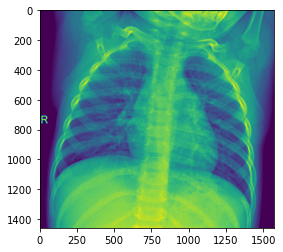

In [7]:
#display(Image.open(img,'r'),)
img = data_path + '/train/NORMAL/'+ files_list_normal_train[np.random.randint(0,len(files_list_normal_train))]
print(plt.imread(img).shape)
img = mpimg.imread(img)
imgplot = plt.imshow(img)
plt.show()

(696, 952)


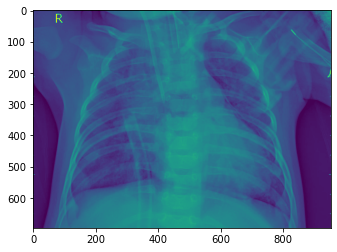

In [8]:
img = data_path + '/train/PNEUMONIA/'+ files_list_pneu_train[np.random.randint(0,len(files_list_pneu_train))]
print(plt.imread(img).shape)
img = mpimg.imread(img)
imgplot = plt.imshow(img)
plt.show()

### before data augmentation --run this

In [9]:
train_transform = transforms.Compose([transforms.Resize(224),transforms.CenterCrop(224),transforms.ToTensor(),\
                                      transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])
test_transform = transforms.Compose([transforms.Resize(224),transforms.CenterCrop(224),transforms.ToTensor(),\
                                     transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

In [10]:
train_data = datasets.ImageFolder(os.path.join(data_path,'train'), transform= train_transform)
test_data = datasets.ImageFolder(os.path.join(data_path,'test'), transform= test_transform)

train_loader = DataLoader(train_data,batch_size= 16, shuffle= True, pin_memory= True)
test_loader = DataLoader(test_data,batch_size= 1, shuffle= False, pin_memory= True)


In [11]:
class_names = train_data.classes
print(class_names)
print(f'Number of train images: {len(train_data)}')
print(f'Number of test images: {len(test_data)}')

['NORMAL', 'PNEUMONIA']
Number of train images: 5232
Number of test images: 624


In [12]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block  --nn.BatchNorm2d(4)
        self.convblock1 = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=8,\
                                                  kernel_size=(3, 3),padding=0, bias=False),nn.ReLU())
            
        self.pool11 = nn.MaxPool2d(2, 2)

        # CONVOLUTION BLOCK ,#nn.BatchNorm2d(16)
        self.convblock2 = nn.Sequential(nn.Conv2d(in_channels=8, out_channels=16,\
                                          kernel_size=(3, 3),padding=0, bias=False),nn.ReLU())

        # TRANSITION BLOCK
        self.pool22 = nn.MaxPool2d(2, 2)
        
        #nn.BatchNorm2d(10),
        self.convblock3 = nn.Sequential(nn.Conv2d(in_channels=16, out_channels=10,\
                                                   kernel_size=(1, 1), padding=0, bias=False),nn.ReLU())
                                         
 
        self.pool33 = nn.MaxPool2d(2, 2)
                                         
         # CONVOLUTION BLOCK  #nn.BatchNorm2d(10)
        self.convblock4 = nn.Sequential(nn.Conv2d(in_channels=10, out_channels=10,\
                                                   kernel_size=(3, 3), padding=0, bias=False),nn.ReLU())
        
        #nn.BatchNorm2d(32),
        self.convblock5 = nn.Sequential(nn.Conv2d(in_channels=10, out_channels=32,\
                                                  kernel_size=(1, 1), padding=0, bias=False),nn.ReLU())

        #nn.BatchNorm2d(10),
        self.convblock6 = nn.Sequential(nn.Conv2d(in_channels=32, out_channels=10,\
                                                  kernel_size=(1, 1), padding=0, bias=False),nn.ReLU())

        #nn.BatchNorm2d(10)
        self.convblock7 = nn.Sequential(nn.Conv2d(in_channels=10, out_channels=10,\
                                                   kernel_size=(3, 3), padding=0, bias=False),nn.ReLU())

        #nn.BatchNorm2d(32),
        self.convblock8 = nn.Sequential(nn.Conv2d(in_channels=10, out_channels=32,
                                                  kernel_size=(1, 1), padding=0, bias=False),nn.ReLU())

        #nn.BatchNorm2d(10),
        self.convblock9 = nn.Sequential(nn.Conv2d(in_channels=32, out_channels=10,\
                                                  kernel_size=(1, 1), padding=0, bias=False),nn.ReLU())

        #nn.BatchNorm2d(14),
        self.convblock10 = nn.Sequential(nn.Conv2d(in_channels=10, out_channels=14,\
                                                    kernel_size=(3, 3), padding=0, bias=False),nn.ReLU() )

        #nn.BatchNorm2d(16),
        self.convblock11 = nn.Sequential(nn.Conv2d(in_channels=14, out_channels=16,\
                                                   kernel_size=(3, 3), padding=0, bias=False), nn.ReLU())

         # OUTPUT BLOCK
        self.gap = nn.Sequential(nn.AvgPool2d(kernel_size=4))

        self.convblockout = nn.Sequential(nn.Conv2d(in_channels=16, out_channels=2, kernel_size=(4, 4), padding=0, bias=False))
                                 
    def forward(self, x):
        x = self.convblock1(x)
        x = self.pool11(x)
        x = self.convblock2(x)
        x = self.pool22(x)
        x = self.convblock3(x)
        x = self.pool33(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.convblock9(x)
        x = self.convblock10(x)
        x = self.convblock11(x)
        x = self.gap(x)
        x = self.convblockout(x)
        x = x.view(-1, 2)
        return F.log_softmax(x, dim=-1)

In [13]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Available processor {}".format(device))
model = Net().to(device)
summary(model, input_size=(3, 224, 224))

Available processor cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 222, 222]             216
              ReLU-2          [-1, 8, 222, 222]               0
         MaxPool2d-3          [-1, 8, 111, 111]               0
            Conv2d-4         [-1, 16, 109, 109]           1,152
              ReLU-5         [-1, 16, 109, 109]               0
         MaxPool2d-6           [-1, 16, 54, 54]               0
            Conv2d-7           [-1, 10, 54, 54]             160
              ReLU-8           [-1, 10, 54, 54]               0
         MaxPool2d-9           [-1, 10, 27, 27]               0
           Conv2d-10           [-1, 10, 25, 25]             900
             ReLU-11           [-1, 10, 25, 25]               0
           Conv2d-12           [-1, 32, 25, 25]             320
             ReLU-13           [-1, 32, 25, 25]               0
           Conv

In [54]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

In [55]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        # get data
        data, target = data.to(device), target.to(device)
        # Initialization of gradient
        optimizer.zero_grad()
        # In PyTorch, gradient is accumulated over backprop and 

        # or specific requirements
        ## prediction on data
        y_pred = model(data)
        # Calculating loss given the prediction
        loss = F.nll_loss(y_pred, target)
        train_losses.append(loss)
        # Backprop
        loss.backward()
        optimizer.step()
        # get the index of the log-probability corresponding to the max value

        pred = y_pred.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)

In [56]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, 
            reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{}({:.2f}%)\n'.format(test_loss, correct,\
                                                                                len(test_loader.dataset),100. * correct / len(test_loader.dataset)))
    test_acc.append(100. * correct / len(test_loader.dataset))

In [57]:
model = Net().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, 
momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.5)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    print('current Learning Rate: ', optimizer.state_dict()["param_groups"][0]["lr"])
    test(model, device, test_loader)

EPOCH: 0


Loss=0.693148672580719 Batch_id=326 Accuracy=26.38: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 327/327 [03:25<00:00,  1.59it/s]


current Learning Rate:  0.01

Test set: Average loss: 0.6931, Accuracy: 237/624(37.98%)

EPOCH: 1


Loss=0.693147599697113 Batch_id=326 Accuracy=28.33: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 327/327 [02:30<00:00,  2.18it/s]


current Learning Rate:  0.01

Test set: Average loss: 0.6931, Accuracy: 247/624(39.58%)

EPOCH: 2


Loss=0.6931471228599548 Batch_id=326 Accuracy=34.44: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 327/327 [02:28<00:00,  2.20it/s]


current Learning Rate:  0.01

Test set: Average loss: 0.6931, Accuracy: 311/624(49.84%)

EPOCH: 3


Loss=0.6931470036506653 Batch_id=326 Accuracy=56.08: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 327/327 [02:29<00:00,  2.19it/s]


current Learning Rate:  0.01

Test set: Average loss: 0.6931, Accuracy: 449/624(71.96%)

EPOCH: 4


Loss=0.6931464076042175 Batch_id=326 Accuracy=77.87: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 327/327 [02:28<00:00,  2.20it/s]


current Learning Rate:  0.01

Test set: Average loss: 0.6931, Accuracy: 466/624(74.68%)

EPOCH: 5


Loss=0.6931466460227966 Batch_id=326 Accuracy=79.93: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 327/327 [02:29<00:00,  2.19it/s]


current Learning Rate:  0.005

Test set: Average loss: 0.6931, Accuracy: 413/624(66.19%)

EPOCH: 6


Loss=0.6931455731391907 Batch_id=326 Accuracy=76.66: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 327/327 [02:28<00:00,  2.20it/s]


current Learning Rate:  0.005

Test set: Average loss: 0.6931, Accuracy: 403/624(64.58%)

EPOCH: 7


Loss=0.6931444406509399 Batch_id=326 Accuracy=75.06: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 327/327 [02:35<00:00,  2.10it/s]


current Learning Rate:  0.005

Test set: Average loss: 0.6931, Accuracy: 393/624(62.98%)

EPOCH: 8


Loss=0.6931446194648743 Batch_id=326 Accuracy=74.45: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 327/327 [02:32<00:00,  2.14it/s]


current Learning Rate:  0.005

Test set: Average loss: 0.6931, Accuracy: 391/624(62.66%)

EPOCH: 9


Loss=0.6931453347206116 Batch_id=326 Accuracy=74.24: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 327/327 [02:33<00:00,  2.13it/s]


current Learning Rate:  0.005

Test set: Average loss: 0.6931, Accuracy: 390/624(62.50%)

EPOCH: 10


Loss=0.6931446194648743 Batch_id=326 Accuracy=74.22: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 327/327 [02:53<00:00,  1.88it/s]


current Learning Rate:  0.005

Test set: Average loss: 0.6931, Accuracy: 390/624(62.50%)

EPOCH: 11


Loss=0.6931445598602295 Batch_id=326 Accuracy=74.22: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 327/327 [03:06<00:00,  1.75it/s]


current Learning Rate:  0.0025

Test set: Average loss: 0.6931, Accuracy: 390/624(62.50%)

EPOCH: 12


Loss=0.6931435465812683 Batch_id=326 Accuracy=74.22: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 327/327 [03:03<00:00,  1.78it/s]

current Learning Rate:  0.0025



Test set: Average loss: 0.6931, Accuracy: 390/624(62.50%)

EPOCH: 13


Loss=0.6931464672088623 Batch_id=326 Accuracy=74.22: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 327/327 [03:01<00:00,  1.80it/s]


current Learning Rate:  0.0025

Test set: Average loss: 0.6931, Accuracy: 390/624(62.50%)

EPOCH: 14


Loss=0.6931453347206116 Batch_id=326 Accuracy=74.22: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 327/327 [03:00<00:00,  1.81it/s]


current Learning Rate:  0.0025

Test set: Average loss: 0.6931, Accuracy: 390/624(62.50%)



Text(0.5, 1.0, 'Test Accuracy')

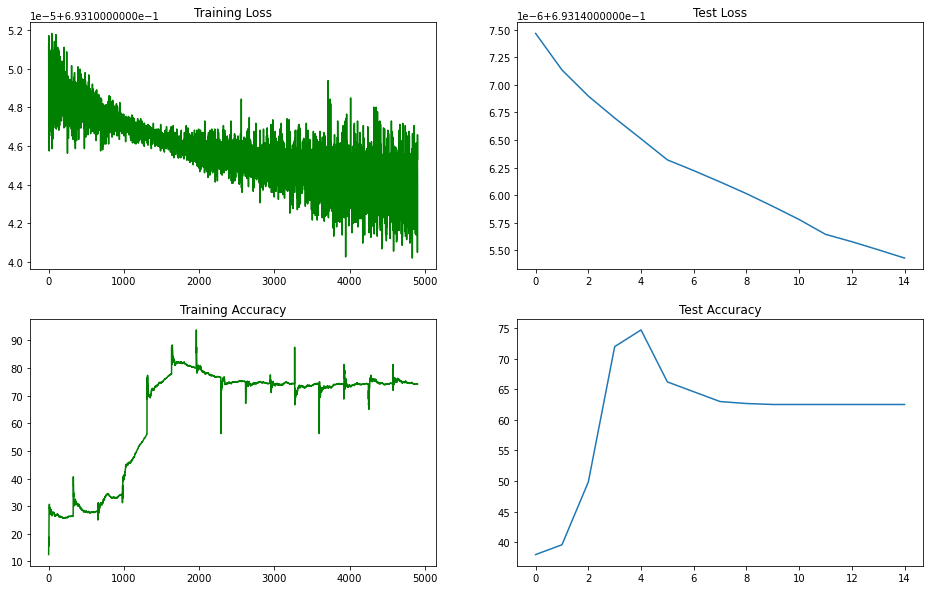

In [58]:
train_losses1 = [float(i.cpu().detach().numpy()) for i in train_losses]
train_acc1 = [i for i in train_acc]
test_losses1 = [i for i in test_losses]
test_acc1 = [i for i in test_acc]
fig, axs = plt.subplots(2,2,figsize=(16,10))
axs[0, 0].plot(train_losses1,color='green')
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc1,color='green')
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses1)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc1)
axs[1, 1].set_title("Test Accuracy")

### after data uagmentation -- run this (only compose function was edited).

In [59]:
train_transform = transforms.Compose([transforms.Resize(224),transforms.CenterCrop(224),\
                                      transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),\
                                      transforms.RandomHorizontalFlip(), transforms.RandomRotation(10),\
                                      transforms.ToTensor(),\
                                      transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])
test_transform = transforms.Compose([transforms.Resize(224),transforms.CenterCrop(224),transforms.ToTensor(),\
                                     transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

In [60]:
class_names = train_data.classes
print(class_names)
print(f'Number of train images: {len(train_data)}')
print(f'Number of test images: {len(test_data)}')
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block  --nn.BatchNorm2d(4)
        self.convblock1 = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=8,\
                                                  kernel_size=(3, 3),padding=0, bias=False),nn.ReLU())
            
        self.pool11 = nn.MaxPool2d(2, 2)

        # CONVOLUTION BLOCK ,#nn.BatchNorm2d(16)
        self.convblock2 = nn.Sequential(nn.Conv2d(in_channels=8, out_channels=16,\
                                          kernel_size=(3, 3),padding=0, bias=False),nn.ReLU())

        # TRANSITION BLOCK
        self.pool22 = nn.MaxPool2d(2, 2)
        
        #nn.BatchNorm2d(10),
        self.convblock3 = nn.Sequential(nn.Conv2d(in_channels=16, out_channels=10,\
                                                   kernel_size=(1, 1), padding=0, bias=False),nn.ReLU())
                                         
 
        self.pool33 = nn.MaxPool2d(2, 2)
                                         
         # CONVOLUTION BLOCK  #nn.BatchNorm2d(10)
        self.convblock4 = nn.Sequential(nn.Conv2d(in_channels=10, out_channels=10,\
                                                   kernel_size=(3, 3), padding=0, bias=False),nn.ReLU())
        
        #nn.BatchNorm2d(32),
        self.convblock5 = nn.Sequential(nn.Conv2d(in_channels=10, out_channels=32,\
                                                  kernel_size=(1, 1), padding=0, bias=False),nn.ReLU())

        #nn.BatchNorm2d(10),
        self.convblock6 = nn.Sequential(nn.Conv2d(in_channels=32, out_channels=10,\
                                                  kernel_size=(1, 1), padding=0, bias=False),nn.ReLU())

        #nn.BatchNorm2d(10)
        self.convblock7 = nn.Sequential(nn.Conv2d(in_channels=10, out_channels=10,\
                                                   kernel_size=(3, 3), padding=0, bias=False),nn.ReLU())

        #nn.BatchNorm2d(32),
        self.convblock8 = nn.Sequential(nn.Conv2d(in_channels=10, out_channels=32,
                                                  kernel_size=(1, 1), padding=0, bias=False),nn.ReLU())

        #nn.BatchNorm2d(10),
        self.convblock9 = nn.Sequential(nn.Conv2d(in_channels=32, out_channels=10,\
                                                  kernel_size=(1, 1), padding=0, bias=False),nn.ReLU())

        #nn.BatchNorm2d(14),
        self.convblock10 = nn.Sequential(nn.Conv2d(in_channels=10, out_channels=14,\
                                                    kernel_size=(3, 3), padding=0, bias=False),nn.ReLU() )

        #nn.BatchNorm2d(16),
        self.convblock11 = nn.Sequential(nn.Conv2d(in_channels=14, out_channels=16,\
                                                   kernel_size=(3, 3), padding=0, bias=False), nn.ReLU())

         # OUTPUT BLOCK
        self.gap = nn.Sequential(nn.AvgPool2d(kernel_size=4))

        self.convblockout = nn.Sequential(nn.Conv2d(in_channels=16, out_channels=2, kernel_size=(4, 4), padding=0, bias=False))
                                 
    def forward(self, x):
        x = self.convblock1(x)
        x = self.pool11(x)
        x = self.convblock2(x)
        x = self.pool22(x)
        x = self.convblock3(x)
        x = self.pool33(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.convblock9(x)
        x = self.convblock10(x)
        x = self.convblock11(x)
        x = self.gap(x)
        x = self.convblockout(x)
        x = x.view(-1, 2)
        return F.log_softmax(x, dim=-1)
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Available processor {}".format(device))
model = Net().to(device)
summary(model, input_size=(3, 224, 224))

['NORMAL', 'PNEUMONIA']
Number of train images: 5232
Number of test images: 624
Available processor cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 222, 222]             216
              ReLU-2          [-1, 8, 222, 222]               0
         MaxPool2d-3          [-1, 8, 111, 111]               0
            Conv2d-4         [-1, 16, 109, 109]           1,152
              ReLU-5         [-1, 16, 109, 109]               0
         MaxPool2d-6           [-1, 16, 54, 54]               0
            Conv2d-7           [-1, 10, 54, 54]             160
              ReLU-8           [-1, 10, 54, 54]               0
         MaxPool2d-9           [-1, 10, 27, 27]               0
           Conv2d-10           [-1, 10, 25, 25]             900
             ReLU-11           [-1, 10, 25, 25]               0
           Conv2d-12           [-1, 32, 25, 25]             320

In [61]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        # get data
        data, target = data.to(device), target.to(device)
        # Initialization of gradient
        optimizer.zero_grad()
        # In PyTorch, gradient is accumulated over backprop and 

        # or specific requirements
        ## prediction on data
        y_pred = model(data)
        # Calculating loss given the prediction
        loss = F.nll_loss(y_pred, target)
        train_losses.append(loss)
        # Backprop
        loss.backward()
        optimizer.step()
        # get the index of the log-probability corresponding to the max value

        pred = y_pred.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, 
            reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{}({:.2f}%)\n'.format(test_loss, correct,\
                                                                                len(test_loader.dataset),100. * correct / len(test_loader.dataset)))
    test_acc.append(100. * correct / len(test_loader.dataset))

model = Net().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, 
momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.5)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    print('current Learning Rate: ', optimizer.state_dict()["param_groups"][0]["lr"])
    test(model, device, test_loader)

EPOCH: 0


Loss=0.6931421160697937 Batch_id=326 Accuracy=74.20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 327/327 [03:30<00:00,  1.55it/s]


current Learning Rate:  0.01

Test set: Average loss: 0.6931, Accuracy: 390/624(62.50%)

EPOCH: 1


Loss=0.6931418776512146 Batch_id=326 Accuracy=74.20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 327/327 [03:00<00:00,  1.81it/s]


current Learning Rate:  0.01

Test set: Average loss: 0.6931, Accuracy: 390/624(62.50%)

EPOCH: 2


Loss=0.693142831325531 Batch_id=326 Accuracy=74.22: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 327/327 [02:58<00:00,  1.83it/s]


current Learning Rate:  0.01

Test set: Average loss: 0.6931, Accuracy: 390/624(62.50%)

EPOCH: 3


Loss=0.6931431293487549 Batch_id=326 Accuracy=74.22: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 327/327 [02:59<00:00,  1.83it/s]


current Learning Rate:  0.01

Test set: Average loss: 0.6931, Accuracy: 390/624(62.50%)

EPOCH: 4


Loss=0.6931393146514893 Batch_id=326 Accuracy=74.22: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 327/327 [02:59<00:00,  1.82it/s]


current Learning Rate:  0.01

Test set: Average loss: 0.6931, Accuracy: 390/624(62.50%)

EPOCH: 5


Loss=0.6931344866752625 Batch_id=326 Accuracy=74.22: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 327/327 [03:00<00:00,  1.81it/s]


current Learning Rate:  0.005

Test set: Average loss: 0.6931, Accuracy: 390/624(62.50%)

EPOCH: 6


Loss=0.6931400895118713 Batch_id=326 Accuracy=74.22: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 327/327 [03:00<00:00,  1.81it/s]


current Learning Rate:  0.005

Test set: Average loss: 0.6931, Accuracy: 390/624(62.50%)

EPOCH: 7


Loss=0.6931418776512146 Batch_id=326 Accuracy=74.22: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 327/327 [02:59<00:00,  1.82it/s]


current Learning Rate:  0.005

Test set: Average loss: 0.6931, Accuracy: 390/624(62.50%)

EPOCH: 8


Loss=0.693123459815979 Batch_id=326 Accuracy=74.22: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 327/327 [02:59<00:00,  1.82it/s]


current Learning Rate:  0.005

Test set: Average loss: 0.6931, Accuracy: 390/624(62.50%)

EPOCH: 9


Loss=0.6931278109550476 Batch_id=326 Accuracy=74.22: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 327/327 [03:01<00:00,  1.80it/s]


current Learning Rate:  0.005

Test set: Average loss: 0.6931, Accuracy: 390/624(62.50%)

EPOCH: 10


Loss=0.693118155002594 Batch_id=326 Accuracy=74.22: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 327/327 [03:00<00:00,  1.81it/s]


current Learning Rate:  0.005

Test set: Average loss: 0.6931, Accuracy: 390/624(62.50%)

EPOCH: 11


Loss=0.69310063123703 Batch_id=326 Accuracy=74.22: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 327/327 [03:00<00:00,  1.82it/s]


current Learning Rate:  0.0025

Test set: Average loss: 0.6931, Accuracy: 390/624(62.50%)

EPOCH: 12


Loss=0.69307541847229 Batch_id=326 Accuracy=74.22: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 327/327 [03:00<00:00,  1.81it/s]


current Learning Rate:  0.0025

Test set: Average loss: 0.6931, Accuracy: 390/624(62.50%)

EPOCH: 13


Loss=0.6930545568466187 Batch_id=326 Accuracy=74.22: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 327/327 [02:59<00:00,  1.82it/s]


current Learning Rate:  0.0025

Test set: Average loss: 0.6931, Accuracy: 390/624(62.50%)

EPOCH: 14


Loss=0.6930700540542603 Batch_id=326 Accuracy=74.22: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 327/327 [03:03<00:00,  1.78it/s]


current Learning Rate:  0.0025

Test set: Average loss: 0.6931, Accuracy: 390/624(62.50%)



Text(0.5, 1.0, 'Test Accuracy')

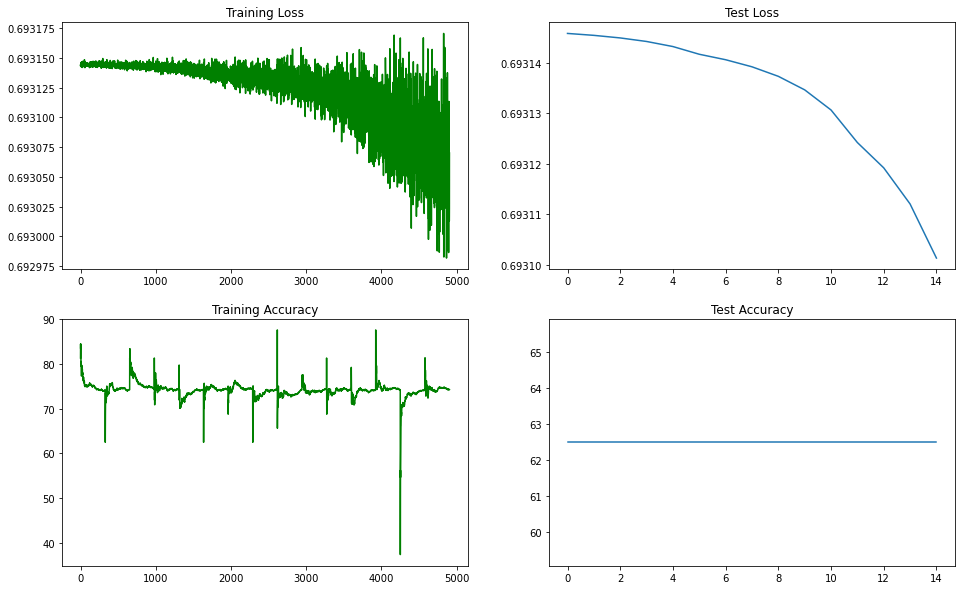

In [62]:
train_losses1 = [float(i.cpu().detach().numpy()) for i in train_losses]
train_acc1 = [i for i in train_acc]
test_losses1 = [i for i in test_losses]
test_acc1 = [i for i in test_acc]
fig, axs = plt.subplots(2,2,figsize=(16,10))
axs[0, 0].plot(train_losses1,color='green')
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc1,color='green')
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses1)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc1)
axs[1, 1].set_title("Test Accuracy")

In [17]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=8,\
                                                  kernel_size=(3, 3), padding=0, bias=False), nn.ReLU(), nn.BatchNorm2d(8))
        self.pool11 = nn.MaxPool2d(2, 2)

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3),\
                                                  padding=0, bias=False),nn.ReLU(),nn.BatchNorm2d(16))

        self.pool22 = nn.MaxPool2d(2, 2)

        self.convblock3 = nn.Sequential(nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1),\
                                                  padding=0, bias=False),nn.ReLU(),nn.BatchNorm2d(10),)

        self.pool33 = nn.MaxPool2d(2, 2)

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3),\
                                                  padding=0, bias=False),nn.ReLU(),nn.BatchNorm2d(10))

        self.convblock5 = nn.Sequential(nn.Conv2d(in_channels=10, out_channels=32, kernel_size=(1, 1),\
                                                  padding=0, bias=False),nn.ReLU(),nn.BatchNorm2d(32),)

        self.convblock6 = nn.Sequential(nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1),
                                                  padding=0, bias=False),nn.ReLU(),nn.BatchNorm2d(10),)

        self.convblock7 = nn.Sequential(nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3),
                                                  padding=0, bias=False),nn.ReLU(),nn.BatchNorm2d(10))

        self.convblock8 = nn.Sequential(nn.Conv2d(in_channels=10, out_channels=32, kernel_size=(1, 1),
                                                  padding=0, bias=False),nn.ReLU(),nn.BatchNorm2d(32))

        self.convblock9 = nn.Sequential(nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1),\
                                                  padding=0, bias=False),nn.ReLU(),nn.BatchNorm2d(10))

        self.convblock10 = nn.Sequential(nn.Conv2d(in_channels=10, out_channels=14, kernel_size=(3, 3),\
                                                   padding=0, bias=False),nn.ReLU(),nn.BatchNorm2d(14))

        self.convblock11 = nn.Sequential(nn.Conv2d(in_channels=14, out_channels=16, kernel_size=(3, 3), \
                                                   padding=0, bias=False),nn.ReLU(),nn.BatchNorm2d(16))

        # OUTPUT BLOCK
        self.gap = nn.Sequential(nn.AvgPool2d(kernel_size=4))

        self.convblockout = nn.Sequential(nn.Conv2d(in_channels=16, out_channels=2, kernel_size=(4, 4),\
                                                    padding=0, bias=False),)
    def forward(self, x):
        x = self.convblock1(x)
        x = self.pool11(x)
        x = self.convblock2(x)
        x = self.pool22(x)
        x = self.convblock3(x)
        x = self.pool33(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.convblock9(x)
        x = self.convblock10(x)
        x = self.convblock11(x)
        x = self.gap(x)
        x = self.convblockout(x)
        x = x.view(-1, 2)
        return F.log_softmax(x, dim=-1)
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Available processor {}".format(device))
model = Net().to(device)
summary(model, input_size=(3, 224, 224))

Available processor cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 222, 222]             216
              ReLU-2          [-1, 8, 222, 222]               0
       BatchNorm2d-3          [-1, 8, 222, 222]              16
         MaxPool2d-4          [-1, 8, 111, 111]               0
            Conv2d-5         [-1, 16, 109, 109]           1,152
              ReLU-6         [-1, 16, 109, 109]               0
       BatchNorm2d-7         [-1, 16, 109, 109]              32
         MaxPool2d-8           [-1, 16, 54, 54]               0
            Conv2d-9           [-1, 10, 54, 54]             160
             ReLU-10           [-1, 10, 54, 54]               0
      BatchNorm2d-11           [-1, 10, 54, 54]              20
        MaxPool2d-12           [-1, 10, 27, 27]               0
           Conv2d-13           [-1, 10, 25, 25]             900
             Re

In [16]:
loss = F.nll_loss(y_pred, target)
l1 = 0
for p in model.parameters():
    l1=l1+p.abs().sum()
    loss = loss+lambda1*l1

NameError: name 'y_pred' is not defined

In [19]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        # get data
        data, target = data.to(device), target.to(device)
        # Initialization of gradient
        optimizer.zero_grad()
        # In PyTorch, gradient is accumulated over backprop and 

        # or specific requirements
        ## prediction on data
        y_pred = model(data)
        
        loss = F.nll_loss(y_pred, target)
        l1 = 0
        for p in model.parameters():
            l1=l1+p.abs().sum()
            loss = loss+lambda1*l1
        # Calculating loss given the prediction
        #loss = F.nll_loss(y_pred, target)
        train_losses.append(loss)
        # Backprop
        loss.backward()
        optimizer.step()
        # get the index of the log-probability corresponding to the max value

        pred = y_pred.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{}({:.2f}%)\n'.format(test_loss, correct,\
                                                                                len(test_loader.dataset),100. * correct / len(test_loader.dataset)))
    test_acc.append(100. * correct / len(test_loader.dataset))

model = Net().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01,momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.5)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    print('current Learning Rate: ', optimizer.state_dict()["param_groups"][0]["lr"])
    test(model, device, test_loader)

EPOCH: 0


  0%|                                                                                          | 0/327 [00:00<?, ?it/s]


NameError: name 'lambda1' is not defined